In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.cluster import DBSCAN
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------------------------
# Class Definitions
# ---------------------------

class PivotPoint:
    def __init__(self, date, open_, high, low, close, volume, pivot_type):
        self.date = date
        self.open = open_
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.pivot_type = pivot_type  # 'high' or 'low'

    def __repr__(self):
        return (f"PivotPoint(date={self.date}, type={self.pivot_type}, "
                f"O={self.open}, H={self.high}, L={self.low}, C={self.close}, V={self.volume})")


class TrendLine:
    def __init__(self, starting_pivot, starting_index):
        self.starting_pivot = starting_pivot
        self.included_pivots = []  # List of tuples: (PivotPoint, row_index)
        self.starting_index = starting_index
        self.end_point = None  # (x, y) coordinates of the endpoint

    def add_pivot(self, pivot_point, pivot_index):
        self.included_pivots.append((pivot_point, pivot_index))

    def calculate_end_point(self, max_index, filtered_data):
        if not self.included_pivots:
            print("No included pivots to calculate the endpoint.")
            return

        first_pivot = self.starting_pivot
        first_index = self.starting_index
        last_pivot, last_index = self.included_pivots[-1]

        # Calculate differences
        difference_x = last_pivot.close - first_pivot.close  # Price difference
        difference_y = last_index - first_index  # Number of rows between pivots

        # Calculate endpoint
        end_price = last_pivot.close + 2 * difference_x
        end_index = last_index + 2 * difference_y

        # Ensure the end_index does not exceed the dataset
        if end_index >= max_index:
            end_index = max_index - 1

        # Get the end date from the dataset
        end_date = filtered_data.index[end_index]

        self.end_point = (end_date, end_price)

    def __repr__(self):
        included_pivots_details = [f"{pp[0].date} (Index: {pp[1]})" for pp in self.included_pivots]
        return (f"TrendLine(starting_pivot={self.starting_pivot}, "
                f"included_pivots={included_pivots_details}, end_point={self.end_point})")

# ---------------------------
# Function Definitions
# ---------------------------

def detect_pivots(filtered_data, pivot_window=5):
    """
    Detects pivot highs and lows in the data and creates PivotPoint objects.

    Parameters:
        filtered_data (pd.DataFrame): The financial data.
        pivot_window (int): Number of preceding candles to consider for pivot detection.

    Returns:
        pivot_points (list): List of PivotPoint objects.
    """
    pivot_points = []
    pivots = []

    for i in range(pivot_window, len(filtered_data)):
        window_highs = filtered_data['high'].iloc[i - pivot_window:i]
        window_lows = filtered_data['low'].iloc[i - pivot_window:i]

        current_high = filtered_data['high'].iloc[i]
        current_low = filtered_data['low'].iloc[i]

        is_pivot_high = current_high > window_highs.max()
        is_pivot_low = current_low < window_lows.min()

        date = filtered_data.index[i]
        open_ = filtered_data['open'].iloc[i]
        high = current_high
        low = current_low
        close = filtered_data['close'].iloc[i]
        volume = filtered_data['volume'].iloc[i]

        if is_pivot_high:
            # Remove previous high pivots that are lower than current
            while pivots and pivots[-1][1] == 'high' and filtered_data['Pivot Highs'].iloc[pivots[-1][0]] < current_high:
                removed_pivot_index, _ = pivots.pop()
                filtered_data.at[filtered_data.index[removed_pivot_index], 'Pivot Highs'] = np.nan

            # Ensure alternating pivot types
            if not pivots or pivots[-1][1] == 'low':
                pivots.append((i, 'high'))
                filtered_data.at[filtered_data.index[i], 'Pivot Highs'] = current_high
                pivot = PivotPoint(date, open_, high, low, close, volume, 'high')
                pivot_points.append(pivot)

        if is_pivot_low:
            # Remove previous low pivots that are higher than current
            while pivots and pivots[-1][1] == 'low' and filtered_data['Pivot Lows'].iloc[pivots[-1][0]] > current_low:
                removed_pivot_index, _ = pivots.pop()
                filtered_data.at[filtered_data.index[removed_pivot_index], 'Pivot Lows'] = np.nan

            # Ensure alternating pivot types
            if not pivots or pivots[-1][1] == 'high':
                pivots.append((i, 'low'))
                filtered_data.at[filtered_data.index[i], 'Pivot Lows'] = current_low
                pivot = PivotPoint(date, open_, high, low, close, volume, 'low')
                pivot_points.append(pivot)

    return pivot_points


def cluster_pivots(pivot_high_values, pivot_low_values, abs_eps=3, min_samples=1):
    """
    Unified clustering for support/resistance (S/R) levels using an absolute `eps`.

    Parameters:
        pivot_high_values (np.array): Array of high pivot values.
        pivot_low_values (np.array): Array of low pivot values.
        abs_eps (float): Absolute distance threshold for DBSCAN clustering.
        min_samples (int): Minimum number of points to form a cluster (default: 1).

    Returns:
        sr_levels (list): List of unified S/R levels.
    """
    # Combine high and low pivot values
    all_pivots = np.concatenate((pivot_high_values, pivot_low_values)).reshape(-1, 1)
    print(f"All Pivots for Clustering: {all_pivots.flatten()}")  # Debug

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=abs_eps, min_samples=min_samples)
    dbscan.fit(all_pivots)
    labels = dbscan.labels_

    # Print debugging information
    print(f"DBSCAN Labels: {labels}")
    unique_labels = set(labels)
    print(f"Unique Labels: {unique_labels}")
    for label in unique_labels:
        count = sum(labels == label)
        print(f"Cluster {label}: {count} points")

    # Extract cluster levels
    sr_levels = []
    for label in unique_labels:
        if label == -1:  # Skip noise points
            continue
        cluster_values = all_pivots[labels == label].flatten()
        sr_levels.append(cluster_values.mean())  # Use the mean of the cluster as the level

    # Ensure levels are sorted for better visualization
    return sorted(sr_levels)


def adjust_pivot_prices(filtered_data):
    """
    Adjust pivot high and low prices within the specified ranges.

    For low pivots:
        - If green candle (C > O): [L - 0.5%, O + 0.5%]
        - If red candle (C < O): [L - 0.5%, C + 0.5%]

    For high pivots:
        - If green candle (C > O): [C - 0.5%, H + 0.5%]
        - If red candle (C < O): [O - 0.5%, H + 0.5%]

    The adjusted pivot price is the midpoint of the allowed range.

    Parameters:
        filtered_data (pd.DataFrame): DataFrame containing pivot highs and lows.

    Returns:
        filtered_data (pd.DataFrame): DataFrame with adjusted pivot prices.
    """
    # Adjust Pivot Lows
    pivot_lows = filtered_data['Pivot Lows'].notna()
    green_candles = filtered_data['close'] > filtered_data['open']
    red_candles = filtered_data['close'] < filtered_data['open']

    # Green candles pivot lows
    adjusted_low_green = (filtered_data['low'] * 0.995 + filtered_data['open'] * 1.005) / 2
    # Red candles pivot lows
    adjusted_low_red = (filtered_data['low'] * 0.995 + filtered_data['close'] * 1.005) / 2

    # Apply adjustments
    filtered_data.loc[pivot_lows & green_candles, 'Pivot Lows'] = adjusted_low_green[pivot_lows & green_candles]
    filtered_data.loc[pivot_lows & red_candles, 'Pivot Lows'] = adjusted_low_red[pivot_lows & red_candles]

    # Adjust Pivot Highs
    pivot_highs = filtered_data['Pivot Highs'].notna()
    # Green candles pivot highs
    adjusted_high_green = (filtered_data['close'] * 0.995 + filtered_data['high'] * 1.005) / 2
    # Red candles pivot highs
    adjusted_high_red = (filtered_data['open'] * 0.995 + filtered_data['high'] * 1.005) / 2

    # Apply adjustments
    filtered_data.loc[pivot_highs & green_candles, 'Pivot Highs'] = adjusted_high_green[pivot_highs & green_candles]
    filtered_data.loc[pivot_highs & red_candles, 'Pivot Highs'] = adjusted_high_red[pivot_highs & red_candles]

    return filtered_data


def find_trend_lines(filtered_data, pivot_points):
    """
    Identify trend lines based on pivot highs and lows and create TrendLine objects.

    Parameters:
        filtered_data (pd.DataFrame): DataFrame containing pivot highs and lows.
        pivot_points (list): List of PivotPoint objects.

    Returns:
        trend_lines (list): List of TrendLine objects.
    """
    trend_lines = []

    # Separate pivot points into highs and lows with their row indices
    pivot_highs = [(p, filtered_data.index.get_loc(p.date)) for p in pivot_points if p.pivot_type == 'high']
    pivot_lows = [(p, filtered_data.index.get_loc(p.date)) for p in pivot_points if p.pivot_type == 'low']

    max_index = len(filtered_data)

    # Find uptrend lines (connecting consecutive pivot lows)
    for i in range(len(pivot_lows) - 1):
        starting_pivot, starting_index = pivot_lows[i]
        ending_pivot, ending_index = pivot_lows[i + 1]

        trend_line = TrendLine(starting_pivot, starting_index)
        trend_line.add_pivot(ending_pivot, ending_index)
        trend_line.calculate_end_point(max_index, filtered_data)
        trend_lines.append(trend_line)

    # Find downtrend lines (connecting consecutive pivot highs)
    for i in range(len(pivot_highs) - 1):
        starting_pivot, starting_index = pivot_highs[i]
        ending_pivot, ending_index = pivot_highs[i + 1]

        trend_line = TrendLine(starting_pivot, starting_index)
        trend_line.add_pivot(ending_pivot, ending_index)
        trend_line.calculate_end_point(max_index, filtered_data)
        trend_lines.append(trend_line)

    return trend_lines


def plot_candlestick_with_pivots_and_sr_levels(filtered_data, sr_levels):
    """
    Plot candlestick chart with pivot points and S/R levels.

    Parameters:
        filtered_data (pd.DataFrame): The financial data with pivot points.
        sr_levels (list): List of support/resistance levels.

    Returns:
        fig (matplotlib.figure.Figure): The matplotlib figure object.
        axlist (list of matplotlib.axes.Axes): List of axes objects.
    """
    # Prepare addplots for S/R levels
    add_lines = []
    for level in sr_levels:
        if level > filtered_data['low'].min() and level < filtered_data['high'].max():
            add_lines.append(mpf.make_addplot([level] * len(filtered_data), color='purple', linestyle='--'))

    # Prepare pivot points for plotting
    pivot_highs_plot = mpf.make_addplot(
        filtered_data['Pivot Highs'], 
        type='scatter', 
        markersize=100, 
        marker='^', 
        color='green', 
        label='Pivot Highs'
    )
    pivot_lows_plot = mpf.make_addplot(
        filtered_data['Pivot Lows'], 
        type='scatter', 
        markersize=100, 
        marker='v', 
        color='red', 
        label='Pivot Lows'
    )

    # Plot the candlestick chart with pivot points and S/R levels, capturing fig and axlist
    fig, axlist = mpf.plot(
        filtered_data,
        type='candle',
        style='charles',
        title='Candlestick Chart with Pivot Points and S/R Levels',
        ylabel='Price',
        volume=True,
        addplot=add_lines + [pivot_highs_plot, pivot_lows_plot],
        figsize=(14, 10),
        tight_layout=True,
        returnfig=True  # Added parameter to capture figure and axes
    )
    print("Candlestick chart with pivot points and S/R levels plotted successfully.")
    return fig, axlist  # Return the figure and axes objects

def print_trend_lines(trend_lines):
    """
    Print the details of each trend line.

    Parameters:
        trend_lines (list): List of TrendLine objects.
    """
    print("\nTrend Lines:")
    for i, trend in enumerate(trend_lines, start=1):
        if trend.end_point is not None:
            print(f"Trend Line {i}:")
            print(f"  Starting Pivot: {trend.starting_pivot}")
            included_pivots_formatted = [f"{pp[0].date} (Index: {pp[1]})" for pp in trend.included_pivots]
            print(f"  Included Pivots: {included_pivots_formatted}")
            print(f"  Endpoint: {trend.end_point}")
            print("-" * 50)
        else:
            print(f"Trend Line {i}: Invalid (No Endpoint Calculated)")
            print("-" * 50)


In [2]:
def plot_trend_lines_only(trend_lines, ax=None):
    """
    Plot trend lines on a given axis to verify their correctness.

    Parameters:
        trend_lines (list): List of TrendLine objects.
        ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, a new plot is created.
    """
    if ax is None:
        # Create a blank figure and axis
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_facecolor('white')  # Set background to white

    # Initialize lists to collect y-values for setting plot limits
    all_y_values = []

    # Iterate through each trend line and plot it
    for idx, trend in enumerate(trend_lines, start=1):
        if trend.end_point is None:
            print(f"Skipping Trend Line {idx}: No endpoint calculated.")
            continue  # Skip trend lines without valid endpoints

        # Extract start and end points
        x_start = trend.starting_pivot.date
        y_start = trend.starting_pivot.close
        x_end, y_end = trend.end_point

        # Ensure that x_start and x_end are datetime objects
        if not isinstance(x_start, pd.Timestamp):
            x_start = pd.to_datetime(x_start)
        if not isinstance(x_end, pd.Timestamp):
            x_end = pd.to_datetime(x_end)

        # Convert datetime to matplotlib's date format
        x_start_num = mdates.date2num(x_start)
        x_end_num = mdates.date2num(x_end)

        # Choose color based on pivot type
        color = 'blue' if trend.starting_pivot.pivot_type == 'low' else 'red'

        # Plot the trend line
        ax.plot(
            [x_start_num, x_end_num],
            [y_start, y_end],
            linestyle='--',
            linewidth=2,
            color=color,
            label='Uptrend Line' if color == 'blue' else 'Downtrend Line'
        )

        # Collect y-values for setting y-limits
        all_y_values.extend([y_start, y_end])

    # Set plot limits if y_values are present and ax is provided
    if all_y_values and ax is not None:
        # Optionally, adjust y-limits if necessary
        # Commenting out to prevent overriding existing y-limits
        # y_min = min(all_y_values) * 0.995  # Slightly lower than min
        # y_max = max(all_y_values) * 1.005  # Slightly higher than max
        # ax.set_ylim(y_min, y_max)
        pass  # Do not adjust y-limits to preserve candlestick chart's settings

    if ax is None:
        # Format x-axis to show dates nicely
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate()  # Auto-format date labels

        # Set labels and title
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.set_title('Trend Lines Verification')

        # Remove duplicate labels in legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

        # Display the plot
        plt.show()
        print("Trend lines plotted on a blank white plot successfully.")
    else:
        # Retrieve the figure from the axis
        fig = ax.figure

        # Update legend to include trend lines without duplicates
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

        # Format x-axis to show dates nicely
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate()

        print("Trend lines overlaid on the existing candlestick chart successfully.")

In [3]:
def plot_trend_lines_as_dots(trend_lines, filtered_data, ax):
    """
    Plot trend lines as dots on the existing candlestick chart.
    
    Parameters:
        trend_lines (list): List of TrendLine objects.
        filtered_data (pd.DataFrame): The financial data with dates as index.
        ax (matplotlib.axes.Axes): The axis to plot on.
    """
    for idx, trend in enumerate(trend_lines, start=1):
        if trend.end_point is None:
            print(f"Skipping Trend Line {idx}: No endpoint calculated.")
            continue  # Skip trend lines without valid endpoints
        
        # Extract start and end points
        x_start = trend.starting_pivot.date
        y_start = trend.starting_pivot.close
        x_end, y_end = trend.end_point
        
        # Ensure the trend line falls within the filtered data's date range
        if x_end < filtered_data.index.min() or x_start > filtered_data.index.max():
            print(f"Skipping Trend Line {idx}: Endpoint {x_end} is outside the data range.")
            continue
        
        try:
            # Get the integer indices for start and end dates
            x_start_idx = filtered_data.index.get_loc(x_start)
            x_end_idx = filtered_data.index.get_loc(x_end)
        except KeyError as e:
            print(f"Skipping Trend Line {idx}: {e}")
            continue  # Skip if start or end date is not found
        
        if x_end_idx == x_start_idx:
            print(f"Skipping Trend Line {idx}: Start and end indices are the same.")
            continue  # Prevent division by zero
        
        # Calculate slope based on index
        slope = (y_end - y_start) / (x_end_idx - x_start_idx)
        
        # Iterate over the indices between start and end (inclusive)
        for current_idx in range(x_start_idx, x_end_idx + 1):
            current_date = filtered_data.index[current_idx]
            y_value = y_start + slope * (current_idx - x_start_idx)
            y_value = round(y_value, 2)
            
            # Plot as dots with increased size and some transparency
            color = 'blue' if trend.starting_pivot.pivot_type == 'low' else 'red'
            ax.scatter(current_idx, y_value, color=color, s=20, alpha=0.7, 
                       label='Uptrend Line' if color == 'blue' else 'Downtrend Line')
    
    # To avoid duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    print("Trend lines plotted as dots on the existing candlestick chart successfully.")


## Main fnc

CSV Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'Plot', 'Plot.1', 'Plot.2', 'Plot.3']
All Pivots for Clustering: [253.515    294.75     289.25625  285.628125 311.381875 329.885625
 327.26375  317.375625 317.381875 307.25375  301.50875  309.128125
 301.879375 279.25375  291.76     298.26     248.402    279.635625
 260.875625 268.126875 291.875625 305.25875  299.505    294.381875
 271.25     285.639375 288.2525   280.       257.625625 267.75375
 270.25375 ]
DBSCAN Labels: [ 0  1  1  1  2  3  3  4  4  2  5  2  5  6  1  5  7  6  8  9  1  2  5  1
  9  1  1  6 10  9  9]
Unique Labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)}
Cluster 0: 1 points
Cluster 1: 8 points
Cluster 2: 4 points
Cluster 3: 2 points
Cluster 4: 2 points
Cluster 5: 4 points
Cluster 6: 3 points
Cluster 7: 1 points
Cluster 8: 1 points
Cluster 9: 4 points
Cluster 10: 1 points
Identified S/R Levels: [np.float

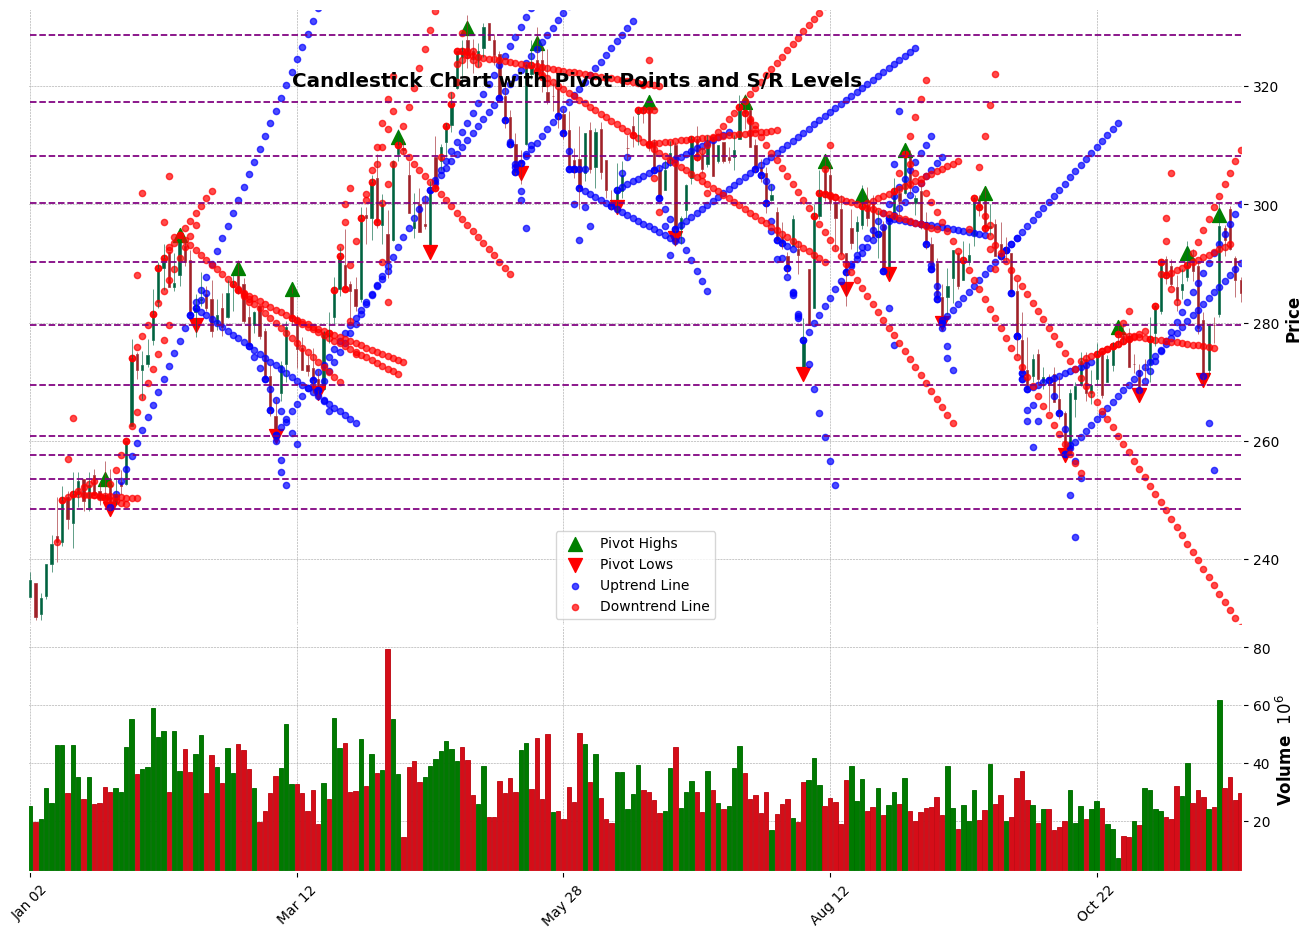

In [4]:
if __name__ == "__main__":
    try:
        # Path to your CSV file
        csv_file = 'data/thy.csv'
        
        # Check if the CSV file exists
        if not os.path.exists(csv_file):
            print(f"CSV file '{csv_file}' does not exist. Please check the path.")
            sys.exit(1)
        
        # Read and display column names (optional)
        data = pd.read_csv(csv_file)
        print("CSV Columns:", data.columns.tolist())
        
        # Parameters
        start_date = '2024-01-01'
        end_date = '2024-12-01'
        pivot_window = 5

        # ---------------------------
        # Step 1: Detect Pivot Points
        # ---------------------------
        filtered_data = data.copy()
        filtered_data['time'] = pd.to_datetime(filtered_data['time'])
        filtered_data.set_index('time', inplace=True)

        filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)].copy()

        # Remove duplicate dates and sort the index
        duplicate_dates = filtered_data.index.duplicated().sum()
        if duplicate_dates > 0:
            print(f"Warning: {duplicate_dates} duplicate dates found in the data. Removing duplicates.")
            filtered_data = filtered_data[~filtered_data.index.duplicated(keep='first')]

        if not filtered_data.index.is_monotonic_increasing:
            print("Sorting the DataFrame index.")
            filtered_data = filtered_data.sort_index()

        required_columns = ['open', 'high', 'low', 'close', 'volume']
        if not all(col in filtered_data.columns for col in required_columns):
            raise ValueError(f"Input data must contain the following columns: {required_columns}")

        # Initialize pivot points columns
        filtered_data['Pivot Highs'] = np.nan
        filtered_data['Pivot Lows'] = np.nan

        # Detect pivot points
        pivot_points = detect_pivots(filtered_data, pivot_window=pivot_window)

        # Adjust pivot prices within allowed ranges
        filtered_data = adjust_pivot_prices(filtered_data)

        # ---------------------------
        # Step 2: Cluster Pivots into S/R Levels
        # ---------------------------
        pivot_high_values = filtered_data['Pivot Highs'].dropna().values
        pivot_low_values = filtered_data['Pivot Lows'].dropna().values

        if len(pivot_high_values) == 0 and len(pivot_low_values) == 0:
            print("No pivot points detected. Exiting function.")
            sys.exit(0)

        sr_levels = cluster_pivots(pivot_high_values, pivot_low_values, abs_eps=3, min_samples=1)

        print(f"Identified S/R Levels: {sr_levels}")

        # ---------------------------
        # Step 3: Calculate Trend Lines
        # ---------------------------
        trend_lines = find_trend_lines(filtered_data, pivot_points)

        # Print trend lines
        print_trend_lines(trend_lines)

        # ---------------------------
        # Step 4: Plot Candlestick Chart with Pivot Points and S/R Levels
        # ---------------------------
        # Capture fig and axlist by modifying the plotting function to return them
        fig, axlist = plot_candlestick_with_pivots_and_sr_levels(filtered_data, sr_levels)

        # ---------------------------
        # Step 5: Overlay Trend Lines as Dots
        # ---------------------------
        plot_trend_lines_as_dots(trend_lines, filtered_data, ax=axlist[0])  # Pass the first axis to overlay trend lines

        # Optional: Save the filtered data with pivot points and S/R levels to a CSV
        output_csv_path = "output_with_pivots_and_sr_levels.csv"
        filtered_data.to_csv(output_csv_path)
        print(f"Filtered data with pivots and S/R levels saved to {output_csv_path}")

        # ---------------------------
        # Step 6: Save Trend Line Points to CSV
        # ---------------------------

        def save_trend_lines_to_csv(trend_lines, filtered_data, output_csv_path):
            """
            Save trend line points for each day to the CSV file.
            
            Parameters:
                trend_lines (list): List of TrendLine objects.
                filtered_data (pd.DataFrame): The financial data with dates as index.
                output_csv_path (str): Path to save the enhanced CSV.
            """
            # Initialize the 'TrendLines' column with empty lists
            filtered_data['TrendLines'] = [[] for _ in range(len(filtered_data))]
            
            for idx, trend in enumerate(trend_lines, start=1):
                if trend.end_point is None:
                    print(f"Skipping Trend Line {idx}: No endpoint calculated.")
                    continue  # Skip trend lines without valid endpoints
                
                # Extract start and end points
                x_start = trend.starting_pivot.date
                y_start = trend.starting_pivot.close
                x_end, y_end = trend.end_point
                
                # Convert to datetime if not already
                if not isinstance(x_start, pd.Timestamp):
                    x_start = pd.to_datetime(x_start)
                if not isinstance(x_end, pd.Timestamp):
                    x_end = pd.to_datetime(x_end)
                
                # Ensure the trend line falls within the filtered data's date range
                if x_end < filtered_data.index.min() or x_start > filtered_data.index.max():
                    print(f"Skipping Trend Line {idx}: Endpoint {x_end} is outside the data range.")
                    continue
                
                # Get the subset of dates between x_start and x_end
                trend_dates = filtered_data.loc[(filtered_data.index >= x_start) & (filtered_data.index <= x_end)].index
                
                # After (Index-based approach):
                x_start_idx = filtered_data.index.get_loc(x_start)
                x_end_idx = filtered_data.index.get_loc(x_end)
                slope = (y_end - y_start) / (x_end_idx - x_start_idx)

                # Now when calculating intermediate points:
                for date in trend_dates:
                    date_idx = filtered_data.index.get_loc(date)
                    y = y_start + slope * (date_idx - x_start_idx)
                    y = round(y, 2)
                    filtered_data.at[date, 'TrendLines'].append(y)
            
            # Convert lists to strings for CSV compatibility
            filtered_data['TrendLines'] = filtered_data['TrendLines'].apply(lambda lst: ';'.join(map(str, lst)) if lst else '')
            
            # Save to CSV
            filtered_data.to_csv(output_csv_path)
            print(f"Filtered data with pivots, S/R levels, and trend lines saved to {output_csv_path}")

        # ---------------------------
        # Step 7: Execute CSV Saving
        # ---------------------------

        # Define the output CSV path
        output_csv_path = "output_with_pivots_sr_trendlines.csv"

        # Call the function to save trend lines to CSV
        save_trend_lines_to_csv(trend_lines, filtered_data, output_csv_path)
    except Exception as e:
        print("An error occurred:", e)
        import traceback
        traceback.print_exc()

### Trendlines should me methodogically changed. too many, some redundant. must save the pivot points and s/r lines seperately. Should automatize.